In [ ]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [ ]:
import models as models
import five_fold_training
import torch
from torch import nn
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, ConcatDataset
from IPython import display
import math
import torchvision
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
train_path = '/content/drive/MyDrive/Data/MM_train_data'
train_data = torch.load(train_path)
test_path = '/content/drive/MyDrive/Data/MM_test_data'
test_data = torch.load(test_path)



In [ ]:
dataset = ConcatDataset([test_data, train_data])

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [ ]:
def train_AE_model(net, dataset, k, epochs, batch_size):
  #https://github.com/christianversloot/machine-learning-articles/blob/main/
  #how-to-use-k-fold-cross-validation-with-pytorch.md

  if __name__ == '__main__':
    
    # Configuration options
    k_folds = k
    epochs = epochs
    #loss_function = nn.CrossEntropyLoss()
    loss_function = nn.MSELoss()
    
    # For fold results
    train_results = {}
    val_results = {}
    
    # Set fixed random number seed
    torch.manual_seed(42)
    
    # Prepare dataset by concatenating Train/Test part; we split later.

    dataset = dataset
    
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=True)
      
    # Start print
    print('--------------------------------')

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
      
      # Print
      print(f'FOLD {fold}')
      print('--------------------------------')
      
      # Sample elements randomly from a given list of ids, no replacement.
      train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
      test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
      
      # Define data loaders for training and testing data in this fold
      trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size, sampler=train_subsampler)
      testloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=batch_size, sampler=test_subsampler)
      

      net = net
      net.apply(reset_weights)

      # create an optimizer object
      # Adam optimizer with learning rate 1e-3
      optimizer = torch.optim.Adam(net.parameters(), lr=0.001)



      # Run the training loop for defined number of epochs
      for epoch in range(1, epochs + 1):
          print(f'\n Epoch {epoch}')
          loss = 0
          training_loss = 0
          test_loss = 0
          val_latents = []
          val_outputs = []
          train_outputs = []
          for i, (batch_features) in enumerate(trainloader):
              optimizer.zero_grad()
              # Reshape data so each image is an array with 784 elements
              batch_features = batch_features.view(-1, 204)

              output, latent = net(batch_features)
              criterion = loss_function(output, batch_features)
              criterion.backward()
              optimizer.step()

              #avg_loss += loss.item()/len(train_data)

              #z, mu_e, logvar_e = net.encode(batch_features)
              #output = net.decode(z)
              
              train_outputs.append(output.detach().numpy())
              
              train_loss = loss_function(output, batch_features)
              
              # Print statistics
              loss += train_loss.item()
              training_loss += train_loss.item()
              
              

              if i % 100 == 0:
                  # Print average loss per sample in batch
                  batch_loss = loss/len(batch_features)
                  print(f'\r[{i:d}/{len(batch_features):d}] batch loss: {batch_loss} ',
                        end='', flush=True)
              loss = 0
            

      # Process is complete.
      print('Training process has finished. Saving trained model.')

      # Print about testing
      #print('Starting testing')

      # Evaluation for this fold

      with torch.no_grad():

        # Iterate over the test data and generate predictions
        for i, (batch_features) in enumerate(testloader):

            # Reshape data so each image is an array with 784 elements
            batch_features = batch_features.view(-1, 204)

            #test_loss = net(batch_features)
            output, latent = net(batch_features)
            
            val_outputs.append(output.detach().numpy())
            val_latents.append(latent.detach().numpy())
            val_loss = loss_function(output, batch_features)




            test_loss += val_loss.item()


        train_outputs = np.concatenate( train_outputs, axis=0 )
        val_outputs = np.concatenate( val_outputs, axis=0 )
        val_latents = np.concatenate( val_latents, axis=0 )
        model_train_loss = training_loss / len(train_outputs
                          )
        test_loss = test_loss / len(val_outputs
                          )
        #animator.add(epoch, (loss, test_loss))
        #print(train_iter[0][:5])
        #print(outputs[:5])




        # Print fold loss
        print(f'Training loss for fold {fold}: {model_train_loss}')
        print(f'Validation loss for fold {fold}: {test_loss}')
        print('--------------------------------')
        train_results[fold] = model_train_loss
        val_results[fold] = test_loss
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    train_sum = 0.0
    val_sum = 0.0
    for key, value in train_results.items():
      print(f'Training Fold {key} Loss: {value}')
      train_sum += value
    print(f'Trainig Average Loss: {train_sum/len(train_results.items())}')
    train_avg_loss = train_sum/len(train_results.items())
    for key, value in val_results.items():
      print(f'Validation Fold {key} Loss: {value} ')
      val_sum += value
    print(f'Vaidation Average Loss: {val_sum/len(val_results.items())}')
    val_avg_loss = val_sum/len(val_results.items())

 
    full_outputs = []
    full_outputs.append(train_avg_loss)
    full_outputs.append(val_avg_loss)
    full_outputs.append(val_latents)
    full_outputs.append(val_outputs)
    full_outputs.append(train_outputs)

    

    return full_outputs


In [ ]:
batch_size = 128
epochs = 50
k = 5
batch_sizes = [64, 128, 512, 1024, 4096, 8192]



In [ ]:
AEnet15 = models.AE2(input_size=204, 
      hidden_size1=196, 
      hidden_size2=128, 
      latent_size=15)

In [ ]:
AE_trained_models = []
for batch_size in batch_sizes:
  globals()['AE' '{0}' '_full_outputs'.format(batch_size)]= train_AE_model(net=AEnet15,
                                          dataset=dataset,
                                          k=k, 
                                          epochs=epochs,
                                          batch_size=batch_size)
  AE_trained_models.append(globals()['AE' '{0}' '_full_outputs'.format(batch_size)])



--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=204, out_features=196, bias=True)
Reset trainable parameters of layer = Linear(in_features=196, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=15, bias=True)
Reset trainable parameters of layer = Linear(in_features=15, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=196, bias=True)
Reset trainable parameters of layer = Linear(in_features=196, out_features=204, bias=True)

 Epoch 1
[500/64] batch loss: 0.0006473666289821267 
 Epoch 2
[500/64] batch loss: 0.0005562445148825645 
 Epoch 3
[500/64] batch loss: 0.0005015531205572188 
 Epoch 4
[500/64] batch loss: 0.0005075919325463474 
 Epoch 5
[500/64] batch loss: 0.0004133160400670022 
 Epoch 6
[500/64] batch loss: 0.000454517372418195 
 Epoch 7
[500/64] batch loss: 0.000448388367658481 
 Epoch 8
[500

In [ ]:
AE_avg_train_loss = []
AE_avg_val_loss = []



In [ ]:
for model in AE_trained_models:
  AE_avg_train_loss.append(model[0])
  AE_avg_val_loss.append(model[1])

In [ ]:
df = pd.DataFrame(data=[batch_sizes,
                        AE_avg_train_loss,
                        AE_avg_val_loss])

df.columns = df.iloc[0]
df = df[1:]

df['Loss'] = ['AE Average training loss',
              'AE Average validation loss']
df = df.set_index('Loss')
df

,64.0,128.0,512.0,1024.0,4096.0,8192.0
Loss,,,,,,
AE Average training loss,0.000275,0.000149,0.000049,0.000028,0.000011,0.000006
AE Average validation loss,0.000307,0.000162,0.000050,0.000028,0.000011,0.000006


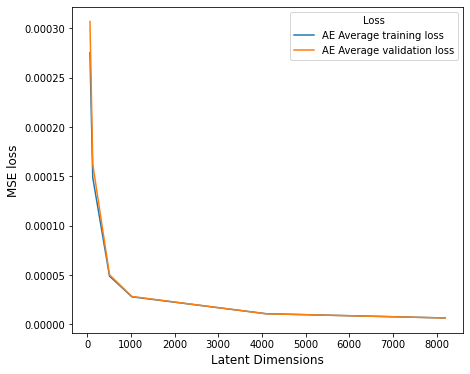

In [ ]:
# transpose and plot
ax = df.T.plot(figsize=(7, 6))
ax.set_ylabel('MSE loss', fontsize=12)
ax.set_xlabel('Latent Dimensions', fontsize=12)
plt.show()

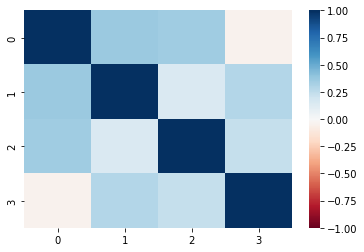

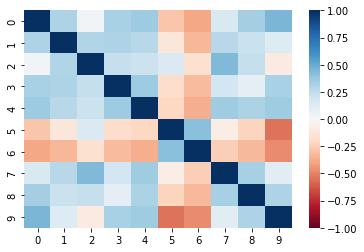

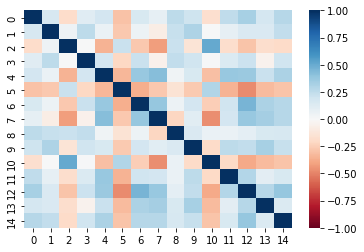

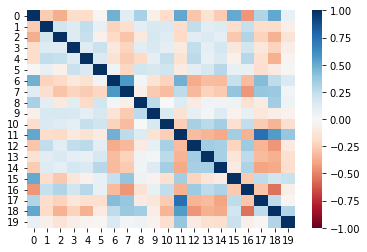

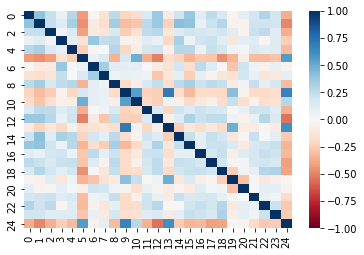

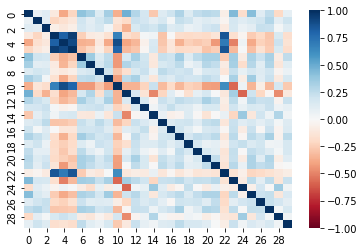

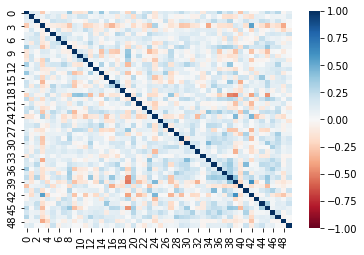

In [ ]:
for model in AE_trained_models:
  val_latents_df = pd.DataFrame(model[2])
  plt.figure()
  sb.heatmap(val_latents_df.corr(), cmap="RdBu", vmin=-1, vmax=1)